In [22]:
import numpy as np # Numerical computing library
import matplotlib.pyplot as plt # Plotting library
import scipy.integrate #Integration library
from mpl_toolkits.mplot3d import axes3d #Used for the 3d bifurcation plot
import matplotlib.patches as mpatches #used to write custom legends
from scipy.special import binom
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import sympy as sym
import math as m

from matplotlib import animation, rc
#import matplotlib.animation as animation
#%matplotlib notebook
#%matplotlib inline
from IPython.display import HTML

from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

%matplotlib inline

In [23]:
#All the right-hand side fucntion will by written under the form: F(t,z)

# return a function of two parameters (time and z) from a function with multi parameters
def func_2_param(f, param):
    def  func(t,z):
        return(f(t,z,param))
    return(func)

# return a function of one parameters (z) from a function with multi parameters
def func_1_param(f,T,param):
    def func(z):
        return(f(T,z,param))
    return(func)

In [24]:
#Parameters
n_Z_mu_200=3
n_Z_m_Z=2
n_mu_200=6
n_S_mu_200=2
n_S_m_Z=2

lam_Z_mu_200=0.1
lam_Z_m_Z=7.5
lam_S_mu_200=0.1
lam_S_m_Z=10.0

k_mu_200=0.05
k_m_Z=0.5
k_Z=0.1

g_Z=0.1*1000.


S0_mu_200=180.*1000.
S0_m_Z=180.*1000.

mu0_200=10.*1000.

g_mu_200=2.1*1000.
g_m_Z=11.
Z0_mu_200=220.*1000.
Z0_m_Z=25.*1000.

L_gamma_m=[0.04, 0.2, 1.0, 1.0, 1.0, 1.0]
L_l=[1, 0.6, 0.3, 0.1, 0.05, 0.05, 0.05]
L_gamma_mu=[0.005, 0.05, 0.5, 0.5, 0.5, 0.5]

# Hill functions

def Hill_minus(B, B0, n):
    return(1./(1+(B/B0)**n))

def Hill_plus(B, B0, n):
    return(1-Hill_minus(B, B0, n))

def Hill_shift(B, B0, n, lam):
    return(Hill_minus(B, B0, n)+lam*Hill_plus(B, B0, n))

alpha=0.15 # parameter that controls the strength of epigenetic regulation; set alpha = 0 for no epigenetic regulation
beta=240. # parameter that controls the timescales at which epigenetic regulation strengthen or weakens' beta -> infinity implies no epigenetic regulation while beta -> 0 implies epigenetic and transcriptional regulations happen on same timescales

In [25]:
#Other functions
def M(n, i, mu, mu0):
    return(((mu/mu0)**i)/((1+mu/mu0)**n))


#mRNA active degradation rate : 

def Y_m(mu, mu0, n, L_gamma_m):
    Y=0
    for i in range(n):
        Y=Y+(L_gamma_m[i]*binom(n,i+1)*M(n, i+1, mu, mu0))
    return(Y)

#miR activ degrdation rate : 

def Y_mu(mu, mu0, n, L_gamma_mu):
    Y=0
    for i in range(n):
        Y=Y+((i+1)*L_gamma_mu[i]*binom(n, i+1)*M(n, i+1, mu, mu0))
    return(Y)

#Translation rate

def L(mu, mu0, n, L_l):
    L=0
    for i in range(n+1):
        L=L+(L_l[i]*binom(n,i)*M(n, i, mu, mu0))
    return(L)

def Q(mu, mu0, n):
    return(k_m_Z*Y_mu(mu, mu0_200, n, L_gamma_mu)/(k_mu_200*(Y_m(mu, mu0_200, n, L_gamma_m)+k_m_Z)))

def P(mu, mu0, n):
    if 1<=n<=2:
        if n==1:
            a=mu0*0.93
            b=0.56
        if n==2:
            a=mu0*0.78
            b=0.20
        return((1-b)/(1+mu/a)+b)
    if 5<=n<=6:
        if n==5:
            a=mu0*0.58
            b=0.004
        if n==6:
            a=mu0*0.45
            b=0.002
            #a=0.45*mu0
            #b=-0.01
        return((1-b)/((1+(mu/a))**2)+b)

In [26]:
def right_side_Z0(t,z, S):
    mu_200=z[0]
    Z=z[1]
    Z0=z[2]
    Hill_Z_mu_200=Hill_shift(Z, Z0, n_Z_mu_200, lam_Z_mu_200)
    Hill_S_mu_200=Hill_shift(S, S0_mu_200, n_S_mu_200, lam_S_mu_200)
    Y_mu_mu_200=Y_mu(mu_200, mu0_200, n_mu_200, L_gamma_mu)

    Hill_Z_m_Z=Hill_shift(Z, Z0_m_Z, n_Z_m_Z, lam_Z_m_Z)
    Hill_S_m_Z=Hill_shift(S, S0_m_Z, n_S_m_Z, lam_S_m_Z)
    Y_m_mu_200=Y_m(mu_200, mu0_200, n_mu_200, L_gamma_m)
    
    L_mu_200=L(mu_200, mu0_200, n_mu_200, L_l)
    
    m0=(g_m_Z*Hill_S_m_Z*Hill_Z_m_Z)/( Y_m_mu_200+k_m_Z)
    f1=(g_mu_200*Hill_Z_mu_200*Hill_S_mu_200)-(m0*Y_mu_mu_200)-(k_mu_200*mu_200)
    f2=(g_Z*m0*L_mu_200)-k_Z*Z
    f3=1/beta*(Z0_mu_200-Z0-alpha*Z)
    return(np.array([f1, f2, f3]))

In [27]:
def particle_adv(functions, U0, Lt): #function: list which contains a, a_prime, r, n0
                                       #U0: concatenate of x0, y0
                                       #Lt: list of time where the solution is computed
    
#    t1_start=process_time()
    U0_solve=[U0[j][i] for j in range(len(U0)) for i in range(len(U0[0]))]
    

    #M=int(len(U0)/4)
    N2=int(len(U0)/2)
    N1=len(U0[0])
    #print(N)
    #print(M)
    Z0_solve=[Z0_mu_200 for i in range(N2*N1)]
    
    U0_solve_final=[*U0_solve, *Z0_solve]
    a, n0=functions[0], functions[1]
    
    def F(t,U):
        x=np.array([U[j*N1: (j+1)*N1] for j in range(0,N2)])
        y=np.array([U[j*N1: (j+1)*N1] for j in range(N2,2*N2)])
        z=np.array([U[j*N1: (j+1)*N1] for j in range(2*N2,3*N2)])
        #w=np.array([U[j*N: (j+1)*N] for j in range(2*M,3*M)])
        #v=np.array([U[j*N: (j+1)*N] for j in range(3*M,4*M)])
        #vw=np.array([U[j*N: (j+1)*N] for j in range(2*M,3*M)])

        X=np.array([[a(t,[x[j][i], y[j][i], z[j][i]])[0] for i in range(N1)] for j in range(N2)])
        Y=np.array([[a(t,[x[j][i], y[j][i], z[j][i]])[1] for i in range(N1)] for j in range(N2)])
        Z=np.array([[a(t,[x[j][i], y[j][i], z[j][i]])[2] for i in range(N1)] for j in range(N2)])
        #rho=np.sum(vw)
        
        #VW=np.array([[(r(np.array([x[j][i], y[j][i]]))-rho)*vw[j][i] for i in range(N)]for j in range(M)])
        #W=np.array([[div_a([x[j][i], y[j][i]])*w[j][i] for i in range(N)]for j in range(M)])
        
        

        
        #V=np.array([[(-div_a([x[j][i], y[j][i]])+(r(np.array([x[j][i], y[j][i]]))-rho))*v[j][i] for i in range(N)]for j in range(M)])
        #V=np.array([(-a_prime(x[i])+r(x[i])-rho)*v[i] for i in range(N)])
        
        #Final=np.concatenate((X, Y, W,V))
        XY=np.concatenate((X, Y))
        Final_1=[XY[j][i] for j in range(len(XY)) for i in range(len(XY[0]))]
        Final_2=[Z[j][i] for j in range(len(Z)) for i in range(len(Z[0]))]
        return([*Final_1, *Final_2])
    sol=solve_ivp(F, (0,Lt[-1]), U0_solve_final,  t_eval=Lt)
    
    Ut=sol.y
#    t1_stop = process_time()
    
#    print("time=%s"% (t1_stop-t1_start))
    return(Ut)

    #return the concatenate of xt, wt, vt



In [28]:
N1=50
N2=50
x0=np.linspace(0.,1., N1)
y0=np.linspace(0., 1., N2)

h=1/((N1-1)*(N2-1))

eps=h**0.5

X0, Y0=np.meshgrid(x0, y0)       #Attention, la coordonnée d'un point  (i,j) est donnée par (X[j][i], Y[j][i]).

U0=np.concatenate((X0, Y0))
U0_solve=[U0[j][i] for j in range(len(U0)) for i in range(len(U0[0]))]

x0_inf=0.5*1000
x0_sup=35.*1000

y0_inf=0.
y0_sup=1000.*1000

def n0(x):
    return(1)


def n0_tilde(x):
    x1, x2=x[0], x[1]
    return(n0(np.array([x0_inf+x1*(x0_sup-x0_inf), y0_inf+x2*(y0_sup-y0_inf)])))

def right_side_tilde_Z0(t,z,S):
    x,y,w =z[0], z[1], z[2]
    return(np.array([1./(x0_sup-x0_inf), 1./(y0_sup-y0_inf), 1])*right_side_Z0(t,np.array([x0_inf+x*(x0_sup-x0_inf), y0_inf+y*(y0_sup-y0_inf),w ]), S))

functions=[func_2_param(right_side_tilde_Z0, 200.*1000), n0]


def gauss(x):
    x_1,x_2=x[0], x[1]
    return((1./m.pi)*m.exp(-(x_1**2+x_2**2)))

print(eps)
print(h**0.5)

x0_ex=np.linspace(x0_inf/1000, x0_sup/1000, N1)
y0_ex=np.linspace(y0_inf/1000, y0_sup/1000, N2)


X0_ex, Y0_ex=np.meshgrid(x0_ex, y0_ex)

0.020408163265306124
0.020408163265306124


In [29]:
def regularisation(X, Y, Ut, cut_off, eps, n0, h):
    
    N2=int(len(U0)/2)
    N1=len(U0[0])
    
    #print(N1)
    #print(N2)

    xt=np.array([Ut[j*N1: (j+1)*N1] for j in range(0,N2)])
    yt=np.array([Ut[j*N1: (j+1)*N1] for j in range(N2,2*N2)])
    
    #wt=np.array([Ut[j*N: (j+1)*N] for j in range(2*M,3*M)])
    #vt=np.array([Ut[j*N: (j+1)*N] for j in range(3*M,4*M)])
    #vwt=np.array([Ut[j*N: (j+1)*N] for j in range(2*M,3*M)])
    #print(xt)
    #print(yt)
    #vwt=vt*wt
    
    #print(np.sum(vwt))
    #print(X)
    #print(Y)
    def ker(x):
        return((1./eps**2)*(cut_off(x/eps)))
    #print(ker(np.array([0, -2])))
    L_fin=[]
    for t in range(len(xt[0][0])):
        print(t)
        
        U_fin=np.array([[ np.sum(np.array([[n0(np.array([X0[j_2][i_2], Y0[j_2][i_2]]))*h*ker(np.array([X[j_1][i_1]-xt[j_2][i_2][t], Y[j_1][i_1]-yt[j_2][i_2][t]])) for i_2 in range(N1)]
                   for j_2 in range(N2)])) for i_1 in range(len(X[0]))]
              for j_1 in range(len(X))])
        

        
        L_fin.append(U_fin)
        
    
    return(L_fin)

In [30]:
x0_ex=np.linspace(x0_inf/1000, x0_sup/1000, N1)
y0_ex=np.linspace(y0_inf/1000, y0_sup/1000, N2)

X0_ex, Y0_ex=np.meshgrid(x0_ex, y0_ex)

In [ ]:
T_S1= 5000.
T_S2=2*T_S1

S0_time=160*1000
S1_time=240*1000
S2_time=160*1000

def S_time(t):
    T_S1= 5000.
    T_S2=2*T_S1

    S0_time=160*1000
    S1_time=240*1000
    S2_time=160*1000

    if t<=T_S1:
        return(S0_time+(S1_time-S0_time)/T_S1*t)
    
    if t>T_S1:
        return(S1_time+(t-T_S1)*(S2_time-S1_time)/(T_S2-T_S1))

In [7]:
def S_time_4(t):
    T_S1=24*50.
    T_S2=T_S1+24*50.
#    T_S4=T_S3+5000

    S0_time=100*1000
    S1_time=240*1000
    S2_time=100*1000

    if t<=T_S1:
        return(S0_time+(S1_time-S0_time)/T_S1*t)
    
#    if T_S1<t<=T_S2:
#        return(S1_time)
    
    if T_S1<t<=T_S2:
        return(S1_time+(t-T_S1)*(S2_time-S1_time)/(T_S2-T_S1))


In [6]:
def S_time_5(t):
    T_S1=24*50.
    T_S2=T_S1+24*50.
    T_S3=T_S2+24*50

    S0_time=100*1000
    S1_time=240*1000
    S2_time=100*1000

    if t<=T_S1:
        return(S0_time+(S1_time-S0_time)/T_S1*t)
    
    if T_S1<t<=T_S2:
        return(S1_time)
    
    if T_S2<t:
        return(S1_time+(t-T_S2)*(S2_time-S1_time)/(T_S3-T_S2))


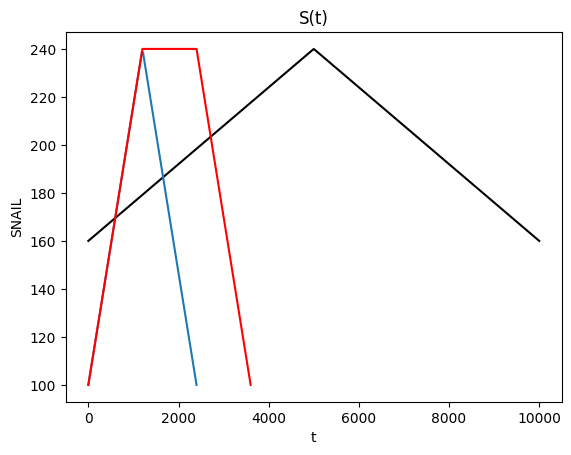

In [10]:
Lt=np.linspace(0, T_S2, 1000)
plt.plot(Lt, [S_time(t)/1000 for t in Lt],color = 'black')
Lt4=np.linspace(0,2*24*50, 100)
plt.plot(Lt4, [S_time_4(t)/1000 for t in Lt4])
Lt5=np.linspace(0, 3*24*50, 100)
plt.plot(Lt5, [S_time_5(t)/1000 for t in Lt5], color='red')
plt.xlabel('t')
plt.ylabel('SNAIL')
plt.title('S(t)')
#plt.plot(Lt, LS, color='blue')
#plt.plot(Lt, LS_2, color='red')

plt.savefig('S(t)_epigenetic_regulation')
plt.show()

In [43]:
def right_side_time(t,z):
    return(right_side_tilde_Z0(t,z,S_time(t)))

In [ ]:
Lt_time=[250*i for i in range(int(10250/250))]

In [45]:
functions=[right_side_time, n0]
sol_time=particle_adv(functions, U0, Lt_time)

In [46]:
L_fin_time1=regularisation(X0, Y0, sol_time, gauss, eps**1., n0_tilde, h)

0
1
2
3
4


In [47]:
L_fin_time_1_reshape=np.array(L_fin_time1).reshape(np.array(L_fin_time1).shape[0], -1)  # redimensionner la matrice 

In [63]:
f=open('a', 'w+')
np.savetxt('a', L_fin_time_1_reshape)

In [125]:
def right_side_time_4(t,z):
    return(right_side_tilde_Z0(t,z,S_time_4(t)))

def right_side_time_5(t,z):
    return(right_side_tilde_Z0(t,z,S_time_5(t)))

In [14]:
Lt_time_4=[50*i for i in range(int((24*50*2+50)/50))]
Lt_time_5=[50*i for i in range(int((24*50*3+50)/50))]

In [ ]:
functions_4=[right_side_time_4, n0]
sol_time_4=particle_adv(functions_4, U0, Lt_time_4)
L_fin_time4=regularisation(X0, Y0, sol_time_4, gauss, eps**1., n0_tilde, h)

In [146]:
L_fin_time_4_reshape=np.array(L_fin_time4).reshape(np.array(L_fin_time4).shape[0], -1)  # redimensionner la matrice 
f=open('a4', 'w+')
np.savetxt('a4', L_fin_time_4_reshape)

In [ ]:
functions_5=[right_side_time_5, n0]
sol_time_5=particle_adv(functions_5, U0, Lt_time_5)
L_fin_time5=regularisation(X0, Y0, sol_time_5, gauss, eps**1., n0_tilde, h)

In [147]:
L_fin_time_5_reshape=np.array(L_fin_time5).reshape(np.array(L_fin_time5).shape[0], -1)  # redimensionner la matrice 
f=open('a5', 'w+')
np.savetxt('a5', L_fin_time_5_reshape)